In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import MY_bcilib as mybci

In [2]:
'''
raw = mne.io.read_raw_gdf('B0101T.gdf', preload=True)
raw.info['ch_names']

raw.drop_channels(['EOG:ch01','EOG:ch02','EOG:ch03'])

custom_mapping = {'769':3,'770':4}
(events_from_annot,event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)
raw_epochs = mne.Epochs(raw, events=events_from_annot, event_id=event_dict,proj=True,baseline=(None, 0), preload=True,tmin=-1,tmax=3.5)

raw_epochs.save('B0101T_epo.fif')
'''

"\nraw = mne.io.read_raw_gdf('B0101T.gdf', preload=True)\nraw.info['ch_names']\n\nraw.drop_channels(['EOG:ch01','EOG:ch02','EOG:ch03'])\n\ncustom_mapping = {'769':3,'770':4}\n(events_from_annot,event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)\nraw_epochs = mne.Epochs(raw, events=events_from_annot, event_id=event_dict,proj=True,baseline=(None, 0), preload=True,tmin=-1,tmax=3.5)\n\nraw_epochs.save('B0101T_epo.fif')\n"

In [3]:
epochs = mne.read_epochs('B0101T_epo.fif')
left_data = epochs['769'].get_data()
right_data = epochs['770'].get_data()

Reading e:\19_BCIexperiment\02_CodeTest\MNE_TEST\B0101T_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    3500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


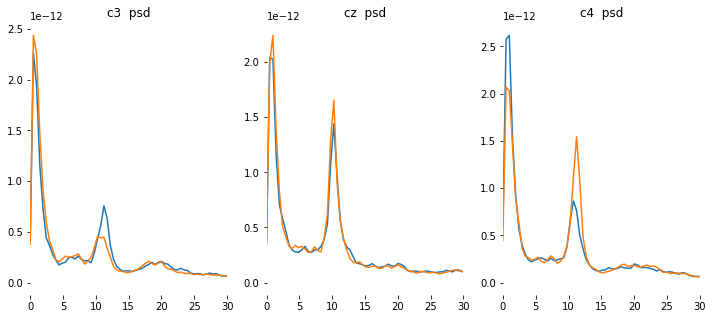

In [4]:
left_psd,freq = mybci.psd(left_data,NFFT=512,Fs=250)
right_psd,freq = mybci.psd(right_data,NFFT=512,Fs=250)

mybci.plot_psd(left_psd,right_psd,freq,['c3','cz','c4'],[0,1,2])

trials_filter shape  (60, 3, 1126)
trials_filter shape  (60, 3, 1126)


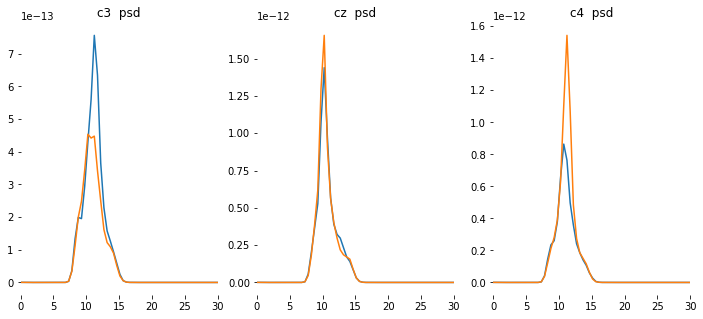

In [5]:
left_data_filt = mybci.band_pass(left_data,8,15,sample_rate=250)
right_data_filt = mybci.band_pass(right_data,8,15,sample_rate=250)

left_filt_psd,freq = mybci.psd(left_data_filt,NFFT=512,Fs=250)
right_filt_psd,freq = mybci.psd(right_data_filt,NFFT=512,Fs=250)

mybci.plot_psd(left_filt_psd,right_filt_psd,freq,['c3','cz','c4'],[0,1,2])


### 使用CSP进行滤波

In [6]:
my_W = mybci.cal_W(left_data_filt,right_data_filt)

my_left_csp_data = mybci.apply_mix(my_W,left_data_filt)
my_right_csp_data = mybci.apply_mix(my_W,right_data_filt)

两类的特征值lambda:
 [0.57589714 0.4838924  0.39505721]
Sb value is  [[ 0.53498191  0.05561515  0.02205722]
 [ 0.05561515  0.55740214 -0.03952342]
 [ 0.02205722 -0.03952342  0.4527692 ]]
reverse Sb value is  [[ 0.53498191  0.05561515  0.02205722]
 [ 0.05561515  0.55740214 -0.03952342]
 [ 0.02205722 -0.03952342  0.4527692 ]]
------------------------


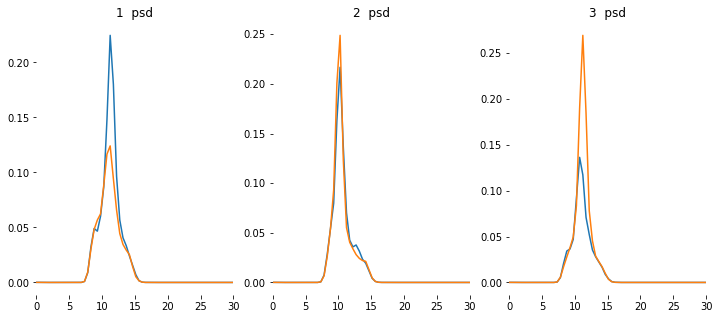

In [7]:
left_csp_filt_psd,freq = mybci.psd(my_left_csp_data,NFFT=512,Fs=250)
right_csp_filt_psd,freq = mybci.psd(my_right_csp_data,NFFT=512,Fs=250)

mybci.plot_psd(left_csp_filt_psd,right_csp_filt_psd,freq,['1','2','3'],[0,1,-1])

(3,)
(3,)


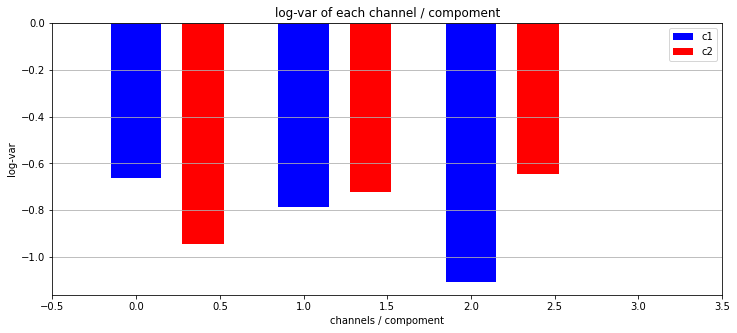

In [8]:
my_left_csp_var = mybci.logvar(my_left_csp_data)
my_right_csp_var = mybci.logvar(my_right_csp_data)
mybci.plot_logvar(my_left_csp_var,my_right_csp_var)

### 切分数据集

In [9]:
all_data = np.zeros((4,60,22,left_data_filt.shape[2]))
train_idx = list(range(0,50))
test_idx = list(range(50,60))
train_left_data = left_data_filt[train_idx,:,:]
train_right_data = right_data_filt[train_idx,:,:]

test_left_data = left_data_filt[test_idx,:,:]
test_right_data = right_data_filt[test_idx,:,:]


train_data = np.concatenate((train_left_data,train_right_data))

test_data = np.concatenate((test_left_data,test_right_data))

test_label = np.concatenate((np.zeros((len(test_idx),)),np.ones((len(test_idx)))))

print('train data shape :',train_data.shape)
print('test data shape :',test_data.shape)
print('test label shape :',test_label.shape)
print('test label data :\n',test_label)

train data shape : (100, 3, 1126)
test data shape : (20, 3, 1126)
test label shape : (20,)
test label data :
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### SVM分类器分类

两类的特征值lambda:
 [0.56676242 0.49328699 0.40851494]
Sb value is  [[ 0.53029828  0.05036936  0.01326448]
 [ 0.05036936  0.5456149  -0.03513408]
 [ 0.01326448 -0.03513408  0.45552246]]
reverse Sb value is  [[ 0.53029828  0.05036936  0.01326448]
 [ 0.05036936  0.5456149  -0.03513408]
 [ 0.01326448 -0.03513408  0.45552246]]
------------------------
(3,)
(3,)


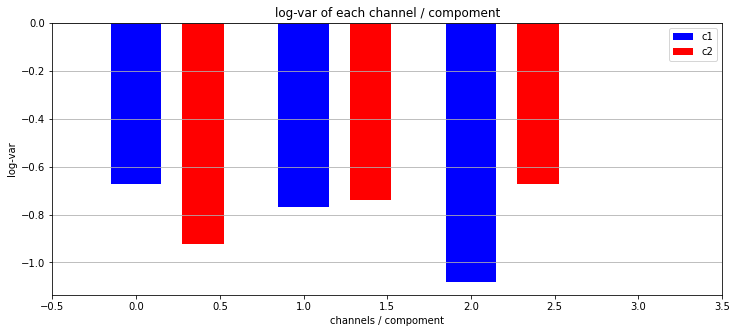

In [10]:
# left v.s. right
W1 = mybci.cal_W(train_left_data,train_right_data)
csp1_left_data = mybci.apply_mix(W1,train_left_data)
csp1_right_data = mybci.apply_mix(W1,train_right_data)


csp1_left_var = mybci.logvar(csp1_left_data)
csp1_right_var = mybci.logvar(csp1_right_data)
mybci.plot_logvar(csp1_left_var,csp1_right_var)



### 提取相应的CSP特征进行训练

In [11]:
from sklearn.svm import SVC


In [12]:
USE_FEATURE = 2  # 0--使用CSP    1--使用PSD   2---使用CSP+PSD

In [13]:
csp_select_component = [0,-1]
psd_select_component = [0,1,-2,-1]

In [14]:
clf1 = SVC(gamma='auto',max_iter = 1000)

csp1_left_var = mybci.logvar(csp1_left_data)
csp1_right_var = mybci.logvar(csp1_right_data)
_ , csp1_left_fea = mybci.cal_csp_feature(csp1_left_var,csp_select_component)
_ , csp1_right_fea = mybci.cal_csp_feature(csp1_right_var,csp_select_component)


csp1_left_psd,freq = mybci.psd(csp1_left_data,NFFT=512,Fs=250)
csp1_right_psd,freq = mybci.psd(csp1_right_data,NFFT=512,Fs=250)
csp1_left_psd = csp1_left_psd[:,psd_select_component,16:30]
csp1_right_psd = csp1_right_psd[:,psd_select_component,16:30]
csp1_left_psd = np.mean(csp1_left_psd,axis=2)
csp1_right_psd = np.mean(csp1_right_psd,axis=2)

csp1_csp = np.concatenate((csp1_left_fea,csp1_right_fea))
csp1_psd = np.concatenate((csp1_left_psd,csp1_right_psd))

if USE_FEATURE==0:
    csp1_train_data = csp1_csp
elif USE_FEATURE==1:
    csp1_train_data = csp1_psd
elif USE_FEATURE==2:
    csp1_train_data = np.concatenate((csp1_csp,csp1_psd),axis=1)



print('csp1_train_data shape : ',csp1_train_data.shape)


csp1_train_label = np.concatenate((np.zeros((csp1_left_fea.shape[0],)),np.ones((csp1_right_fea.shape[0],))))


clf1.fit(csp1_train_data,csp1_train_label)

print(clf1.predict(csp1_train_data))

acc = 1 - np.sum(abs(clf1.predict(csp1_train_data) - csp1_train_label)) / csp1_train_data.shape[0]
print(acc)



csp1_train_data shape :  (100, 6)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1.]
0.72


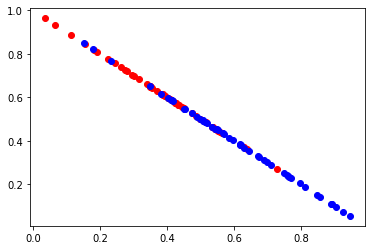

In [15]:
plt.scatter(csp1_train_data[0:50,0],csp1_train_data[0:50,1],c = 'r')
plt.scatter(csp1_train_data[50:100,0],csp1_train_data[50:100,1],c = 'b')

### 获取测试集数据CSP特征以及预测准确率
先在6个分类器上面分别提取CSP特征，然后送入单独的分类器做分类

In [16]:
_,test_csp1 = mybci.cal_csp_feature(mybci.logvar(mybci.apply_mix(W1,test_data)),csp_select_component)

In [17]:
test_psd1,freq = mybci.psd(mybci.apply_mix(W1,test_data),NFFT=512,Fs=250)
test_psd1 = test_psd1[:,psd_select_component,16:30]
test_psd1 = np.mean(test_psd1,axis=2)

In [18]:
if USE_FEATURE==0:
    test_data = test_csp1
elif USE_FEATURE==1:
    test_data = test_psd1
elif USE_FEATURE==2:
    test_data = np.concatenate((test_csp1,test_psd1),axis=1)


In [19]:
clf1_pred = clf1.predict(test_data)

In [22]:
print(clf1_pred)

print(test_label)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
acc = 1 - np.sum(abs(clf1.predict(test_data) - test_label)) / clf1_pred.shape[0]
print(acc)
    

0.8
